<a href="https://colab.research.google.com/github/SofiaSchweitzer/crc_summer_school/blob/main/generative_diffusion_mastersolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generating LHC data with Diffusion Models

#### Background

Simulations for LHC physics is a major computational task at the experiment, and will become more computationally intensive in the coming years, so if ML techniques can speed up some aspects of this then it would be very useful. The process we are studying is Drell-Yan: $pp\rightarrow Z\rightarrow \mu\mu$

#### Interesting papers

- Jet Diffusion versus JetGPT — Modern Networks for the LHC<br>
  *Anja Butter, Nathan Huetsch, Sofia Palacios Schweitzer, Tilman Plehn, Peter Sorrenson, and Jonas Spinner*<br>
  https://arxiv.org/pdf/2305.10475.pdf
- Denoising Diffusion Probabilistic Models<br>
  *Jonathan Ho, Ajay Jain, Pieter Abbeel*<br>
  https://arxiv.org/pdf/2006.11239.pdf
- Flow Matching for Generative Modeling<br>
  *Yaron Lipman, Ricky T. Q. Chen, Heli Ben-Hamu, Maximilian Nickel, Matt Le*<br>
  https://arxiv.org/pdf/2210.02747.pdf

#### Outline

- Imports
- Loading the data
- Study the data
- Preprocessing
- Defining the diffusion model
- Training the model
- Study the results

with a CFM network.

### Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from matplotlib import animation
from IPython.display import HTML

In [ ]:
if torch.cuda.is_available():
    torch.set_default_device("cuda")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
print(device)

cuda


### Loading the data

In [ ]:
!wget "https://www.dropbox.com/scl/fi/gvmelw7u619moo8nyg3j7/ErUMData.zip?e=1&file_subpath=%2Fdy_trn_data.npy&rlkey=kq4do1fmalppjt2v24lzau4li&st=3umjk6s1&dl=0"
!unzip 'ErUMData.zip?e=1&file_subpath=%2Fdy_trn_data.npy&rlkey=kq4do1fmalppjt2v24lzau4li&st=3umjk6s1&dl=0'

--2024-10-02 05:24:49--  https://www.dropbox.com/scl/fi/gvmelw7u619moo8nyg3j7/ErUMData.zip?e=1&file_subpath=%2Fdy_trn_data.npy&rlkey=kq4do1fmalppjt2v24lzau4li&st=3umjk6s1&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc76163b18addffb342cc46f5add.dl.dropboxusercontent.com/cd/0/inline/CbrlfY2HVVAAtKbv502rqrEPZIBEg1AazEKuoJv6Vtx6xzh4PkjsgYnWC-9IGUgNXIQGLRioWwnXslNAzf4cawaPzY0yCpHDPKOxuO8HH9cLNKth9xun--xJ8DZ6B3ozqtw/file# [following]
--2024-10-02 05:24:50--  https://uc76163b18addffb342cc46f5add.dl.dropboxusercontent.com/cd/0/inline/CbrlfY2HVVAAtKbv502rqrEPZIBEg1AazEKuoJv6Vtx6xzh4PkjsgYnWC-9IGUgNXIQGLRioWwnXslNAzf4cawaPzY0yCpHDPKOxuO8HH9cLNKth9xun--xJ8DZ6B3ozqtw/file
Resolving uc76163b18addffb342cc46f5add.dl.dropboxusercontent.com (uc76163b18addffb342cc46f5add.dl.dropboxusercontent.com)... 162.12

In [ ]:
train_data = np.load("dy_trn_data.npy")
val_data = np.load("dy_val_data.npy")
test_data = np.load("dy_tst_data.npy")

In [ ]:
train_data.shape, val_data.shape, test_data.shape

((1384081, 8), (296588, 8), (296588, 8))

Each element of the data has 8 entries, corresponding to the 4-momenta of each muon in the process.

Each entry has the form $[E_1, p_{x,1}, p_{y,1}, p_{z,1}, E_2, p_{x,2}, p_{y,2}, p_{z,2}]$.

### Although studying the data is essential for ML application, the focus of this tutorial lays elsewhere. For now, it is sufficient to simply run the commands of the sections "Study the data" and "Preprocessing" and you can look at them after the tutorial in more detail.

### Study the data

We need to be able to calculate the invariant mass of each event, and the $p_T$ of the event and the jets.

Let's write a function for this:

In [ ]:
def get_obs(events):
    muon1_4m = events[...,0:4]
    muon2_4m = events[...,4:]
    event_4m = muon1_4m + muon2_4m

    event_im = np.sqrt(event_4m[...,0]**2 - event_4m[...,1]**2 - event_4m[...,2]**2 - event_4m[...,3]**2)

    event_pt = np.sqrt(event_4m[...,1]**2 + event_4m[...,2]**2)
    muon1_pt = np.sqrt(muon1_4m[...,1]**2 + muon1_4m[...,2]**2)
    muon2_pt = np.sqrt(muon2_4m[...,1]**2 + muon2_4m[...,2]**2)

    return event_im, event_pt, muon1_pt, muon2_pt

Now test it for the first two events in the training data:

In [ ]:
get_obs(train_data[0:2])

(array([90.98955316, 91.3711254 ]),
 array([0., 0.]),
 array([44.32344982, 35.10745113]),
 array([44.32344982, 35.10745113]))

The $p_T$ of the events will always be zero here due to the fact that the initial incoming protons have no transverse momentum. For the same reason, the $p_T$ of the first and second muon are equal.

Let's get the observables for the whole test dataset:

In [ ]:
test_event_ims, test_event_pts, test_muon1_pts, test_muon2_pts = get_obs(test_data)

Let's plot the invariant mass of the events:

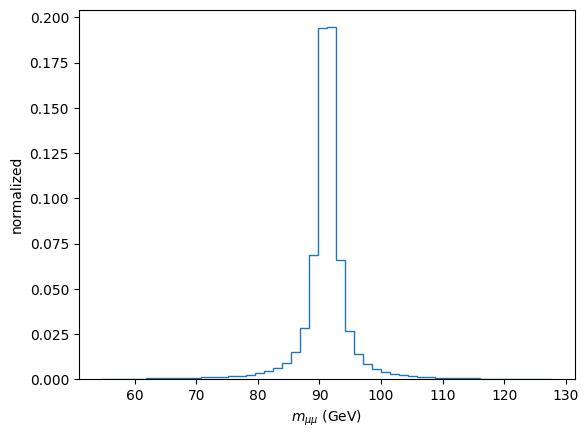

In [ ]:
fig, axs = plt.subplots()
axs.hist(test_event_ims, density=True, bins=50, histtype="step")
axs.set_xlabel("$m_{\mu\mu}$ (GeV)")
axs.set_ylabel("normalized")
plt.show()

Here we see the clear $Z$ mass peak at $\simeq 90$ GeV. Now let's look at $p_T$ distributions:

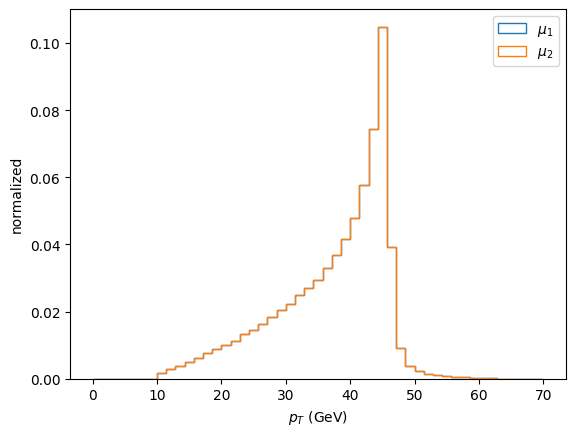

In [ ]:
fig, axs = plt.subplots()

bins = np.linspace(0, 70, 50)
axs.hist(test_muon1_pts, density=True, bins=bins, histtype="step", label=r"$\mu_1$")
axs.hist(test_muon2_pts, density=True, bins=bins, histtype="step", label=r"$\mu_2$")

axs.set_xlabel("$p_{T}$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

These distributions are completely overlapping with a peak near $m_Z/2$.

In the collider the incoming particles have no momentum in the $x$ or $y$ directions, therefore momentum conservation means that the final state should also not have any momentum in these directions.  This means that we have redundant degrees of freedom that can be removed from the data.

We can check this:

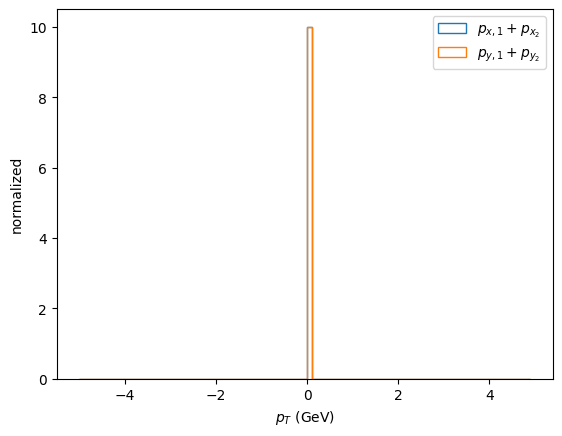

In [ ]:
fig, axs = plt.subplots()

bins = np.arange(-5, 5, step=0.1)
axs.hist(test_data[:,1]+test_data[:,5], density=True, bins=bins, histtype="step", label="$p_{x,1}+p_{x_2}$")
axs.hist(test_data[:,2]+test_data[:,6], density=True, bins=bins, histtype="step", label="$p_{y,1}+p_{y_2}$")

axs.set_xlabel("$p_T$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

Muons have a mass of about $106$ MeV.  This is much smaller than the typical energy scales involved in the Drell-Yan process we are studying, so we can assume to a good approximation that the mass of the final state particles are zero.  These final state particles are on-shell, i.e. $p^2=m^2=0$, so we can also use this as a constraint.  We can check that this approximately holds:

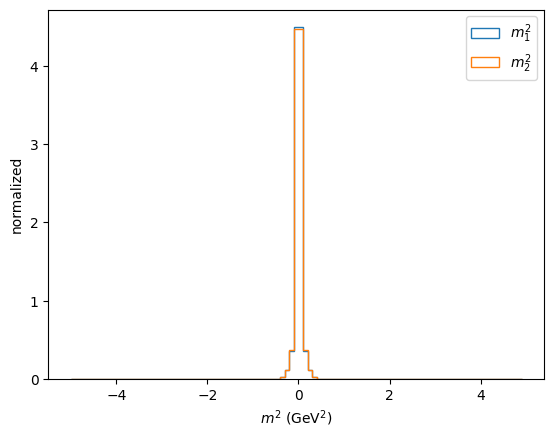

In [ ]:
fig, axs = plt.subplots()

bins = np.arange(-5, 5, step=0.1)
axs.hist(test_data[:,0]**2-test_data[:,1]**2-test_data[:,2]**2-test_data[:,3]**2,
         density=True, bins=bins, label="$m_1^2$", histtype="step")
axs.hist(test_data[:,4]**2-test_data[:,5]**2-test_data[:,6]**2-test_data[:,7]**2,
         density=True, bins=bins, label="$m_2^2$", histtype="step")

axs.set_xlabel("$m^2$ (GeV$^2$)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

We can remove 4 degrees of freedom from the data. For the remaining 4 degrees of freedom, we can choose a more suitable representation that takes into account the symmetries of our data:
- $p_T = \sqrt{p_{x,1}^2+p_{y,1}^2}$
- $\eta_1 = \text{arctanh}\left(\frac{p_{z,1}}{\sqrt{p_{x,1}^2+p_{y,1}^2+p_{z,1}^2}}\right)$
- $\eta_2 = \text{arctanh}\left(\frac{p_{z,2}}{\sqrt{p_{x,2}^2+p_{y,2}^2+p_{z,2}^2}}\right)$
- $\phi = \text{arctan2}(p_{y,1}, p_{x,1})$

### Preprocessing

For data to work well with generative models operating on a Gaussian latent space (a typical choice for diffusion models or normalizing flows), we should avoid sharp edges in the input data. We know that $\phi$ follows a uniform distribution, so we can transform it into something closer to a Gaussian by applying $\text{arctanh}$. We also apply a component-wise normalization step such that the data has a mean of $0$ and a standard deviation of $1$.

Let's write some functions to apply the preprocessing to the training data and invert it for the generated data:

In [ ]:
def apply_preprocessing(data_full):
    pt = np.sqrt(data_full[...,1]**2 + data_full[...,2]**2)
    eta1 = np.arctanh(data_full[...,3] / np.sqrt(data_full[...,1]**2 + data_full[...,2]**2 + data_full[...,3]**2))
    eta2 = np.arctanh(data_full[...,7] / np.sqrt(data_full[...,5]**2 + data_full[...,6]**2 + data_full[...,7]**2))
    phi1 = np.arctanh(np.arctan2(data_full[...,2], data_full[...,1]) / np.pi)
    return np.stack((pt, eta1, eta2, phi1), axis=-1)

def invert_preprocessing(data_red):
    pt = data_red[...,0]
    eta1 = data_red[...,1]
    eta2 = data_red[...,2]
    phi1 = np.arctan(data_red[...,3]) * np.pi
    px1 = pt * np.cos(phi1)
    py1 = pt * np.sin(phi1)
    pz1 = pt * np.sinh(eta1)
    e1 = np.sqrt(px1**2 + py1**2 + pz1**2)
    px2 = -px1
    py2 = -py1
    pz2 = pt * np.sinh(eta2)
    e2 = np.sqrt(px2**2 + py2**2 + pz2**2)
    return np.stack((e1, px1, py1, pz1, e2, px2, py2, pz2), axis=-1)

Now we can apply them to the training data and create a torch Dataset and DataLoader:

In [ ]:
train_data_preproc = apply_preprocessing(train_data)
train_mean = np.mean(train_data_preproc, axis=0)
train_std = np.std(train_data_preproc, axis=0)
train_data_normalized = torch.tensor((train_data_preproc - train_mean) / train_std, dtype=torch.float32)
train_dataset = TensorDataset(train_data_normalized)
train_dataloader = DataLoader(train_data_normalized, batch_size=10000, shuffle=True, generator=torch.Generator(device))

Let's take a look at the data the generative model has to learn:

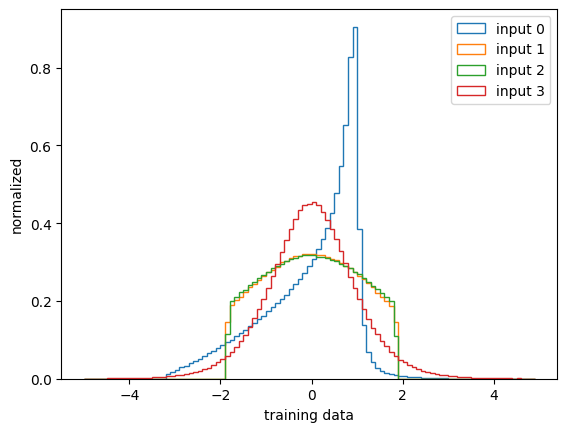

In [ ]:
fig, axs = plt.subplots()

bins = np.arange(-5, 5, step=0.1)
for i in range(4):
    axs.hist(
        train_data_normalized[:, i].cpu().numpy(), density=True, bins=bins, label=f"input {i}", histtype="step"
    )

axs.set_xlabel("training data")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

## Please fill out the blanks.

#### Exercise 1: Conditional Flow Matching

In principle one can categorize Conditional Flow Matching (CFM) models as a specific kind of diffusion model. The idea here is to see the diffusion as a continous process. At time $t=0$ we are in our physical phase space and at time $t=1$ we are in our Gaussian latent space. The process is goverend by a velocity field
\begin{align}
\frac{dx}{dt} = v(x,t)
\end{align}
and its inital condition.
In principle we could learn this veloctiy field as a regression task using a MSE loss. However, how can we define it? We start by describing the diffusion process by a linear trajectory
\begin{align}
x(t, x_0) = (1-t)x_0 + tx_1
\end{align}
with $x_0 \sim p(x_0)$ and $x_1 \sim \mathcal{N}(0,1)$ for at any time t.
The corresponding veloctiy field yields
\begin{align}
v(x,t, x_0) = x_1 - x_0.
\end{align}
Why is this useful? We want to generate $x_0$, why are we interested in learning a quantitiy, which is only defined once $x_0$ is known? Well luckily, it can be shown that
\begin{align}
\mathrm{argmin}_\theta \left< (v_\theta(x_t,t) - v(x,t))^2\right>_{x,t \sim p(x,t)} = \mathrm{argmin}_\theta \left< (v_\theta(x_t,t) - v(x,t,x_0))^2 \right>_{x_0\sim p(x_0), t\sim U(0,1)},
\end{align}
where $v_\theta(x_t,t)$ is the network output. Hence, we have all ingredients to cook a tractable loss function. Once we are finished training we can simply solve
\begin{align}
x_1 - \int_0^1 v_\theta (x,t) d_t
\end{align}
using a fast ODE-sampler.

What is the network input? How many dimensions has the input?


Implement the CFM model loss function using the following steps:
1. Randomly draw the timestep $t$ from a uniform distribution.
2. Sample Gaussian noise.
3. Compute $x_t$ using the function above.
4. Call the network as a function of $x_t$ and $t$.
5. Compute the MSE loss.

In [ ]:
!pip install torchdiffeq

In [ ]:
# use ode solver that can operate on gpu
from torchdiffeq import odeint

class CFM(nn.Module):
    def __init__(
        self,
        data_dim: int,     # number of features in the data
        hidden_dim: int,   # number of hidden layer nodes

    ):
        super().__init__()
        self.data_dim = data_dim

        # TODO: Build network to predict the velocity field with
        # 3 hidden layers with hidden_dim
        self.net = nn.Sequential(
            nn.Linear(data_dim + 1, hidden_dim),nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),nn.ReLU(),
            nn.Linear(hidden_dim, data_dim),
            )

    def batch_loss(
        self,
        x: torch.Tensor, # input data, shape (n_batch, data_dim)
    ) -> torch.Tensor:   # loss, shape (n_batch, )

        # TODO: Implement the batch_loss
        t = torch.rand(size=(x.shape[0], 1))
        noise = torch.randn_like(x)
        xt = (1-t)*x + t*noise
        model_pred = self.net(torch.cat((t.float(),xt.float()), dim=1))
        v = noise - x

        return ((model_pred-v)**2).mean()

    def sample(
        self,
        n_samples: int,        # number of samples
    ) -> torch.Tensor:         # sampled data, shape (n_samples, data_dim) or (n_steps, n_samples, data_dim)
        dtype=torch.float32
        x_1 = torch.randn(n_samples, self.data_dim, device=device, dtype=dtype)

        def net_wrapper(t, x_t):
          t = t * torch.ones_like(x_t[:, [0]], dtype=dtype, device=device)
          nn_out = self.net(torch.cat([t, x_t], dim=1))
          return nn_out

        x_t = odeint(net_wrapper,
                     x_1,
                     torch.tensor([1.,0.], dtype=dtype, device=device)
                             )

        return x_t[-1]

Repeat training and sampling with a CFM.

In [ ]:
cfm = CFM(
    data_dim = 4,
    hidden_dim = 64,
)
epochs = 50

optimizer = torch.optim.Adam(cfm.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, steps_per_epoch=len(train_dataloader), epochs=epochs)

losses = np.zeros(epochs)
for epoch in range(epochs):
    epoch_losses = []
    for batch, x in enumerate(train_dataloader):
        loss = cfm.batch_loss(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_losses.append(loss.item())
    epoch_loss = np.mean(epoch_losses)
    print(f"Epoch {epoch+1}: loss = {epoch_loss}")
    losses[epoch] = epoch_loss

Epoch 1: loss = 1.8848351463139486
Epoch 2: loss = 1.5443241802050913
Epoch 3: loss = 1.4564168093015821
Epoch 4: loss = 1.4420110750541413
Epoch 5: loss = 1.43538868856087
Epoch 6: loss = 1.4324939079421888
Epoch 7: loss = 1.4307027712142726
Epoch 8: loss = 1.4310031263090723
Epoch 9: loss = 1.428210783347809
Epoch 10: loss = 1.427156706508115
Epoch 11: loss = 1.4271848450461737
Epoch 12: loss = 1.4272728806776966
Epoch 13: loss = 1.4281493716960332
Epoch 14: loss = 1.4273438410793278
Epoch 15: loss = 1.4275340425024787
Epoch 16: loss = 1.4256820490034363
Epoch 17: loss = 1.426051742738957
Epoch 18: loss = 1.4264850419202297
Epoch 19: loss = 1.426107377457104
Epoch 20: loss = 1.424280087724864
Epoch 21: loss = 1.425225663528168
Epoch 22: loss = 1.4231824883454138
Epoch 23: loss = 1.4244981952708402
Epoch 24: loss = 1.4219776580659607
Epoch 25: loss = 1.423598488457769
Epoch 26: loss = 1.4227655062572562
Epoch 27: loss = 1.4229795049420364
Epoch 28: loss = 1.4211768572279018
Epoch 29: 

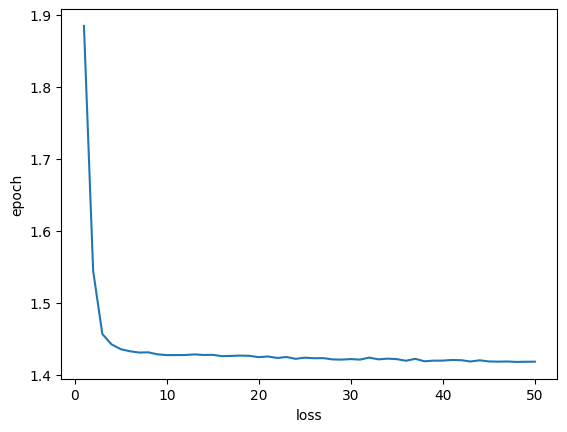

In [22]:
fig, axs = plt.subplots()
axs.plot(np.arange(1, epochs+1), losses)
axs.set_xlabel("loss")
axs.set_ylabel("epoch")
plt.show()

In [23]:
with torch.no_grad():
    sample = cfm.sample(10000).cpu().numpy()
sample_pp = invert_preprocessing(sample * train_std + train_mean)
gen_event_im, _, gen_pt, _ = get_obs(sample_pp)

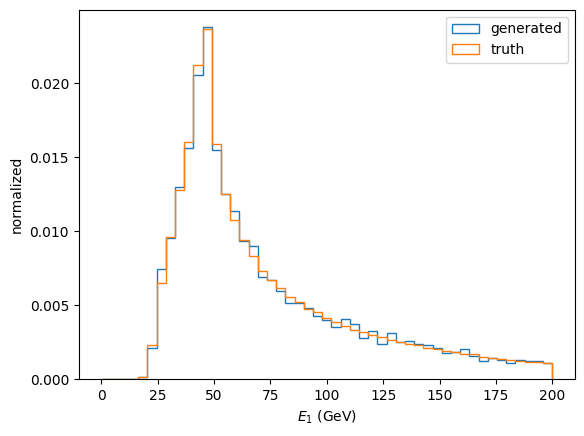

In [24]:
fig, axs = plt.subplots()

bins = np.linspace(0,200,50)
axs.hist(sample_pp[:,0], bins=bins, density=True, histtype="step", label="generated")
axs.hist(test_data[:,0], bins=bins, density=True, histtype="step", label="truth")

axs.set_xlabel("$E_1$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

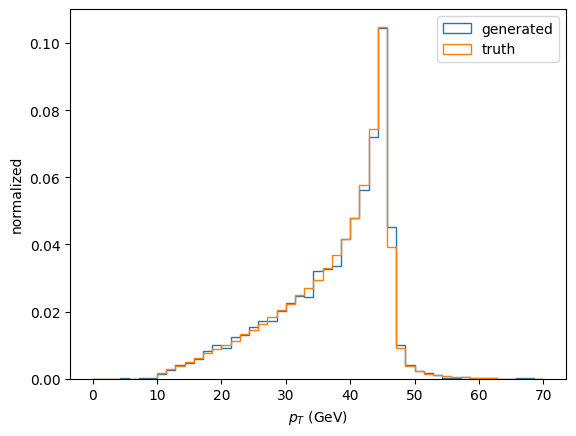

In [25]:
fig, axs = plt.subplots()

bins = np.linspace(0, 70, 50)
axs.hist(gen_pt, bins=bins, density=True, histtype="step", label="generated")
axs.hist(test_muon1_pts, bins=bins, density=True, histtype="step", label="truth")

axs.set_xlabel("$p_T$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

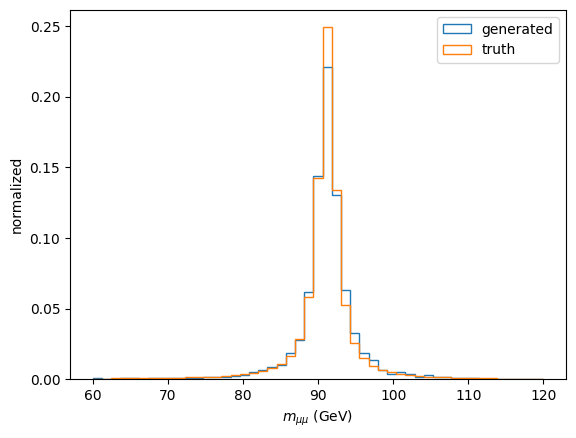

In [26]:
fig, axs = plt.subplots()

bins = np.linspace(60, 120, 50)
axs.hist(gen_event_im, bins=bins, density=True, histtype="step", label="generated")
axs.hist(test_event_ims, bins=bins, density=True, histtype="step", label="truth")

axs.set_xlabel("$m_{\mu\mu}$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

## Bonus exercise

### Defining the diffusion model
A Denoising Diffusion Probabilistic Model (DDPM) is a diffusion model, which - in the forward direction - gradually adds noise to a given phase space point $x_0\sim p(x_0)$ follwing a noise scheduler $\beta_t$. After $T$ discrete time steps only Gaussian noise is left. For a given time $t$ we can show that under this formalism
\begin{align}
x(t,x_0) = \sqrt{1-\bar{\beta}_t} x_0 + \sqrt{\bar{\beta}_t} \epsilon
\end{align}
holds, with $1- \bar{\beta}_t = \prod_{i=0}^{t} (1-\beta_i)$ and $\epsilon\sim\mathcal{N}(0,1)$.
The ML tasks is it starting from a Gaussian sample $x_T\sim \mathcal{N}(0,1)$ to gradually remove or *denoise* this sample until it resembels a point in our physical phase space $x_0 \sim p(x_0)$. In practise we learn $\epsilon_\theta(x_t,t)$, the amount of noise added at time $t$ by a MSE loss. After training we can substract $\epsilon_\theta$ step-by-step. Note that in literatur often times $\alpha_i := (1-\beta_i)$ is introduced.

#### Exercise 1: Diffusion loss function
Implement the diffusion model loss function using the following steps:
1. Randomly draw the timestep $t$ from a uniform distribution.
2. Sample Gaussian noise.
3. Compute $x_t$ using the function `compute_xt` as explained above
4. Compute the prefactor of the loss using `compute_relative_factor` (this is to ensure that the loss is a likelihood loss)
5. Call the network as a function of $x_t$ and $t$
6. Compute the MSE loss with the correct prefactor.

In [ ]:
class DDPM(nn.Module):
    def __init__(
        self,
        data_dim: int,     # number of features in the data
        n_steps: int,      # number of time steps
        n_layers: int,     # number of network layers
        hidden_dim: int,   # number of hidden layer nodes

    ):
        super().__init__()
        self.data_dim = data_dim
        self.n_steps = n_steps

        # Initialize alpha, beta and sigma constants for the given number of time steps
        self.betas = self.linear_beta_schedule(n_steps)

        alphas = 1 - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)
        alphas_bar_prev = F.pad(alphas_bar[:-1], (1, 0), value=1.)
        self.one_minus_alphas_bar = 1 - alphas_bar
        self.sqrt_alphas = torch.sqrt(alphas)
        self.sqrt_alphas_bar = torch.sqrt(alphas_bar)
        self.sqrt_one_minus_alphas_bar = torch.sqrt(self.one_minus_alphas_bar)
        self.sigmas = torch.sqrt(self.betas)

        # Build network
        layers = []
        layer_dim_in = data_dim + 1
        for i in range(n_layers - 1):
            layers.append(nn.Linear(layer_dim_in, hidden_dim))
            layers.append(nn.ReLU())
            layer_dim_in = hidden_dim
        layers.append(nn.Linear(layer_dim_in, data_dim))
        torch.nn.init.zeros_(layers[-1].weight)
        torch.nn.init.zeros_(layers[-1].bias)
        self.net = nn.Sequential(*layers)

    def linear_beta_schedule(
        self,
        n_steps: int   # number of time steps
    ) -> torch.Tensor: # beta values at the time steps, shape (n_steps, )
        scale = 1000 / n_steps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return torch.linspace(beta_start, beta_end, n_steps, dtype=torch.float64)

    def compute_xt(
        self,
        x0: torch.Tensor,    # data point x_0, shape (n_batch, data_dim)
        t: torch.Tensor,     # time step, shape (n_batch, 1)
        noise: torch.Tensor, # gaussian noise, shape (n_batch, data_dim)
    ) -> torch.Tensor:       # noisy point x_t, shape (n_batch, data_dim)
        # TODO: Compute x_t as explained above
        return self.sqrt_alphas_bar[t] * x0 + self.sqrt_one_minus_alphas_bar[t] * noise

    def compute_relative_factor(
        self,
        t: torch.Tensor, # time step, shape (n_batch, 1)
    ) -> torch.Tensor:   # prefactor inside the MSE loss, shape (n_batch, 1)
        return self.betas[t] / (np.sqrt(2) * self.sigmas[t] * self.sqrt_alphas[t] * self.sqrt_one_minus_alphas_bar[t])

    def compute_mu_tilde_t(
        self,
        xt: torch.Tensor,    # noisy point x_t, shape (n_batch, data_dim)
        t: torch.Tensor,     # time step, shape (n_batch, 1)
        noise: torch.Tensor, # gaussian noise, shape (n_batch, data_dim)
    ) -> torch.Tensor:       # computes mu_tilde_t, shape (n_batch, data_dim)
        return (xt - noise * self.betas[t] / self.sqrt_one_minus_alphas_bar[t]) / self.sqrt_alphas[t]

    def batch_loss(
        self,
        x: torch.Tensor, # input data, shape (n_batch, data_dim)
    ) -> torch.Tensor:   # loss, shape (n_batch, )
        # TODO: Compute the batch loss.%
        t = torch.randint(low=1, high=self.n_steps, size=(x.shape[0], 1))
        noise = torch.randn_like(x)
        xt = self.compute_xt(x, t, noise)
        c = self.compute_relative_factor(t)
        model_pred = self.net(torch.cat((xt.float(), t.float()), dim=1))
        return F.mse_loss(c * model_pred, c * noise)

    def sample(
        self,
        n_samples: int,        # number of samples
        keep_xt: bool = False, # whether to keep the intermediate x_t
    ) -> torch.Tensor:         # sampled data, shape (n_samples, data_dim) or (n_steps, n_samples, data_dim)
        x = torch.randn(n_samples, self.data_dim)
        if keep_xt:
            xts = torch.zeros((n_samples, self.n_steps + 1, self.data_dim))
            xts[:, self.n_steps] = x
        for t in reversed(range(self.n_steps)):
            z = torch.randn(n_samples, self.data_dim) if t > 0 else 0.
            model_pred = self.net(torch.cat((x, torch.full((x.shape[0], 1), t, dtype=torch.float32)), dim=1))
            x = self.compute_mu_tilde_t(x, t, model_pred) + self.sigmas[t] * z
            if keep_xt:
                xts[:, t] = x
        return xts if keep_xt else x

### Training the model

In [ ]:
ddpm = DDPM(
    data_dim = 4,
    n_steps = 100,
    n_layers = 3,
    hidden_dim = 64,
)
epochs = 50

optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, steps_per_epoch=len(train_dataloader), epochs=epochs)

losses = np.zeros(epochs)
for epoch in range(epochs):
    epoch_losses = []
    for batch, x in enumerate(train_dataloader):
        loss = ddpm.batch_loss(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_losses.append(loss.item())
    epoch_loss = np.mean(epoch_losses)
    print(f"Epoch {epoch+1}: loss = {epoch_loss}")
    losses[epoch] = epoch_loss

Epoch 1: loss = 0.06588070228352762
Epoch 2: loss = 0.029324043261038647
Epoch 3: loss = 0.026505663040783715
Epoch 4: loss = 0.02589672951369364
Epoch 5: loss = 0.0253723582330689
Epoch 6: loss = 0.025163103944647484
Epoch 7: loss = 0.02547140455312581
Epoch 8: loss = 0.025190173818078542
Epoch 9: loss = 0.024678613411358727
Epoch 10: loss = 0.024857732033721408
Epoch 11: loss = 0.024407194735673536
Epoch 12: loss = 0.024539823720538635
Epoch 13: loss = 0.024354898871820393
Epoch 14: loss = 0.024309689529809025
Epoch 15: loss = 0.024171054313214292
Epoch 16: loss = 0.024038003787144307
Epoch 17: loss = 0.024144608653749754
Epoch 18: loss = 0.02406455683341372
Epoch 19: loss = 0.024160807701525264
Epoch 20: loss = 0.02391303091061138
Epoch 21: loss = 0.023991459870522258
Epoch 22: loss = 0.024013379739954013
Epoch 23: loss = 0.023985050555558864
Epoch 24: loss = 0.023920999489567954
Epoch 25: loss = 0.023780653849247112
Epoch 26: loss = 0.02383923188263722
Epoch 27: loss = 0.0239059881

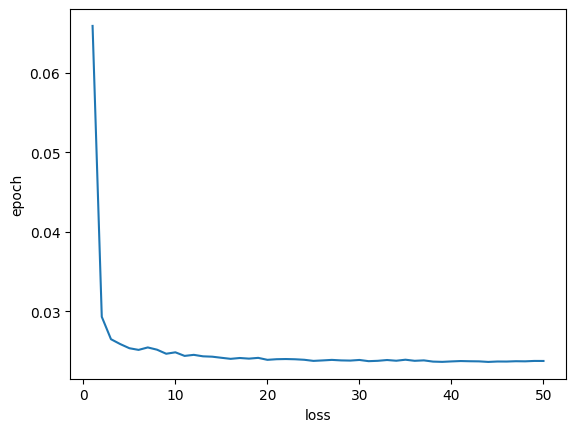

In [ ]:
fig, axs = plt.subplots()
axs.plot(np.arange(1, epochs+1), losses)
axs.set_xlabel("loss")
axs.set_ylabel("epoch")
plt.show()

### Study the results

Let's generate some samples, invert the preprocessing and compute the observables from above:

In [ ]:
with torch.no_grad():
    sample = ddpm.sample(10000).cpu().numpy()
sample_pp = invert_preprocessing(sample * train_std + train_mean)
gen_event_im, _, gen_pt, _ = get_obs(sample_pp)

We can now plot some observables and compare them to the truth distribution. We start with the energy of the first muon.

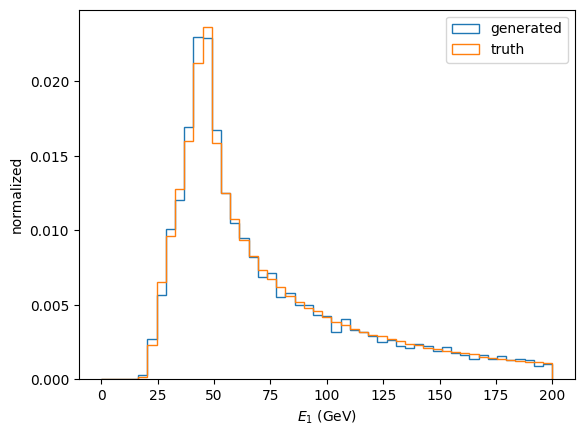

In [ ]:
fig, axs = plt.subplots()

bins = np.linspace(0,200,50)
axs.hist(sample_pp[:,0], bins=bins, density=True, histtype="step", label="generated")
axs.hist(test_data[:,0], bins=bins, density=True, histtype="step", label="truth")

axs.set_xlabel("$E_1$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

That looks quite nice! Next, we look at the $p_T$ again.

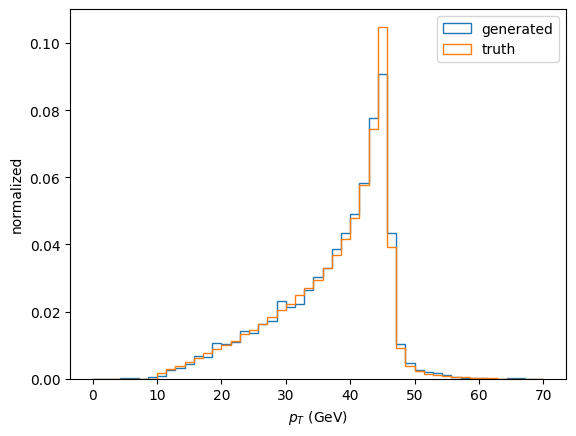

In [ ]:
fig, axs = plt.subplots()

bins = np.linspace(0, 70, 50)
axs.hist(gen_pt, bins=bins, density=True, histtype="step", label="generated")
axs.hist(test_muon1_pts, bins=bins, density=True, histtype="step", label="truth")

axs.set_xlabel("$p_T$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

We can see that it is difficult for the network to learn the sharp edge near $m_Z$. Learning such features is a typical difficulty of generative networks. Finally, we can take a look at $m_{\mu\mu}$. This observable is challenging to learn because the network needs to extract the correlation between different features correctly.

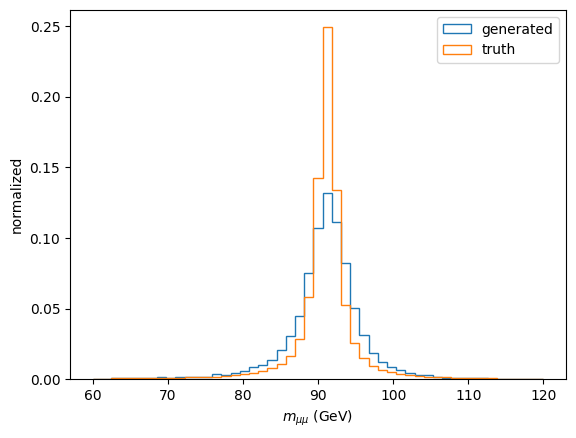

In [ ]:
fig, axs = plt.subplots()

bins = np.linspace(60, 120, 50)
axs.hist(gen_event_im, bins=bins, density=True, histtype="step", label="generated")
axs.hist(test_event_ims, bins=bins, density=True, histtype="step", label="truth")

axs.set_xlabel("$m_{\mu\mu}$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

#### Exercise 2: Other observables

Make histograms of the $\phi$ and $\eta$ observables for the first muon.

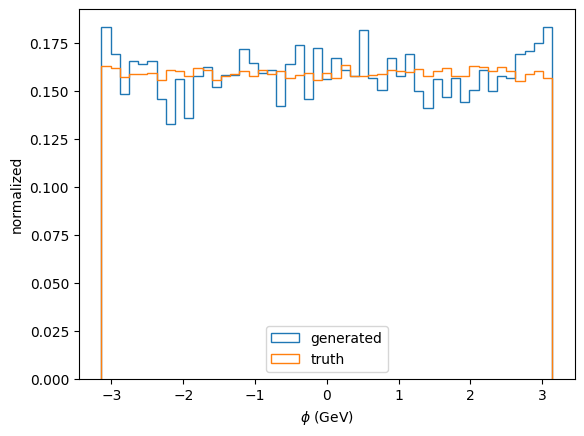

In [ ]:
fig, axs = plt.subplots()

bins = np.linspace(-np.pi, np.pi, 50)
gen_phi = np.arctan2(sample_pp[:,2], sample_pp[:,1])
test_phi = np.arctan2(test_data[:,2], test_data[:,1])
axs.hist(gen_phi, bins=bins, density=True, histtype="step", label="generated")
axs.hist(test_phi, bins=bins, density=True, histtype="step", label="truth")

axs.set_xlabel(r"$\phi$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()

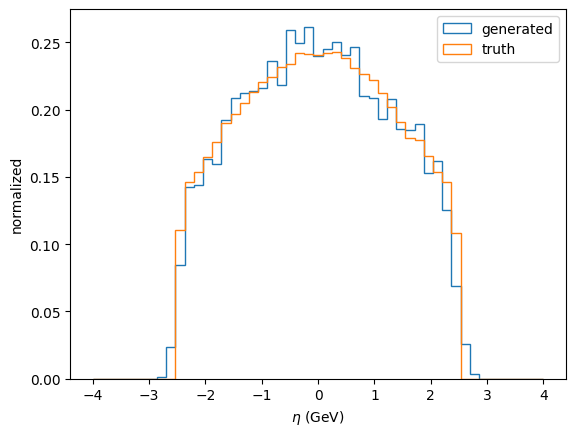

In [ ]:
fig, axs = plt.subplots()

bins = np.linspace(-4, 4, 50)
gen_eta = np.arctanh(sample_pp[:,3] / np.sqrt(sample_pp[:,1]**2 + sample_pp[:,2]**2 + sample_pp[:,3]**2))
test_eta = np.arctanh(test_data[:,3] / np.sqrt(test_data[:,1]**2 + test_data[:,2]**2 + test_data[:,3]**2))
axs.hist(gen_eta, bins=bins, density=True, histtype="step", label="generated")
axs.hist(test_eta, bins=bins, density=True, histtype="step", label="truth")

axs.set_xlabel(r"$\eta$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
plt.show()